## Objective:
- Fit a One vs All classifier for for different types of variable stars
- Use several different classifier methods: Random Forest, Decision Tree, Logistic Regression, Naive Bayes
- Create a comparision table for different classifiers and labels. Compare using metrics like accuracy, precision and recall

In [1]:
#Load libraries
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Complete features and label table from Xiadian's website

In [2]:
widths = (8,7,4,13,43)
header_pd = pd.read_fwf('../databases/Labeled_data.txt', widths = widths,skiprows=7, nrows=27)
labeled_data = pd.read_csv('../databases/Labeled_data.txt', header=None, delim_whitespace=True, skiprows=36) # extract data
labeled_data.columns = header_pd.iloc[:,3]
labeled_data.head()
label = labeled_data.Type.unique()
label = np.delete(label, np.where(label == 'CEPII')) # CEPII has very few samples so we ignore it
print(label)

['BYDra' 'EW' 'SR' 'RSCVN' 'RR' 'DSCT' 'EA' 'Mira' 'RRc' 'CEP']


## Import features extracted from light curves
These features are caluclated on 1000 light curves of each variable type. The light curves are imported from variables.cn:88/
Feature list
- mean : mean of the light curve
- wmean : weight mean of the light curve
- MAD : deviation about the median
- IQR : inter quartile percentile of the light curve
- f60 : 60 percentile  of light curve
- f70 : 70 percentile of the light curve
- f80 : 80 percentile of the light curve
- f90 : 90 percentile of the light curve
- skew : skewness of the light curve
- kurtosis : kurtosis of the light curve
- welsk_k, welsh_j : welsh and staton J and K statistics of the light curve
- g_ : g band filter
- r_ : r band filter

In [3]:
df = pd.read_csv('../features/features10000.csv', header=None, skiprows=1)
header = pd.read_csv('../features/features10000.csv', header=None, nrows=1)
df.columns = header.iloc[0]

In [4]:
df.head()

,sourceid,ID,RAdeg,DEdeg,g_mean,g_wmean,g_MAD,g_IQR,g_f60,g_f70,...,r_IQR,r_f60,r_f70,r_f80,r_f90,r_skew,r_kurtosis,r_welsh_J,r_welsh_K,Type
0,1.0,ZTFJ000000.13+620605.8,0.000566,62.101631,17.994656,17.992102,0.034,0.07000,0.0820,0.10000,...,0.05125,0.0580,0.06655,0.0797,0.09370,0.105202,-0.632720,40.723268,1678.291273,BYDra
1,2.0,ZTFJ000000.14+721413.7,0.000620,72.237174,19.619402,19.579923,0.111,0.22650,0.2850,0.35950,...,0.22750,0.2712,0.30765,0.3614,0.44115,0.334634,-0.775188,258.579275,3360.702573,EW
2,3.0,ZTFJ000000.19+320847.2,0.000795,32.146449,15.313984,15.313984,0.072,0.14200,0.1580,0.18300,...,0.12600,0.1470,0.16080,0.1760,0.18860,-0.212606,-1.485137,171.745322,891.052032,EW
3,4.0,ZTFJ000000.26+311206.3,0.001085,31.201756,16.353295,16.353295,0.077,0.14900,0.1710,0.18700,...,0.10200,0.1322,0.15980,0.1946,0.20560,0.418285,-1.009552,202.025570,966.503331,EW
4,6.0,ZTFJ000000.30+233400.5,0.001249,23.566828,17.892283,17.878715,0.102,0.18975,0.2526,0.28225,...,0.22900,0.2700,0.29620,0.3132,0.33620,0.158998,-1.484462,253.787215,1019.579800,EW


In [5]:
# Drop rows with Blank values
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)

In [6]:
# get all unique labels
label = df.Type.unique()
print(label)

['BYDra' 'EW' 'SR' 'RSCVN' 'RR' 'DSCT' 'EA' 'RRc' 'Mira' 'CEP']


<AxesSubplot:xlabel='Type', ylabel='Count'>

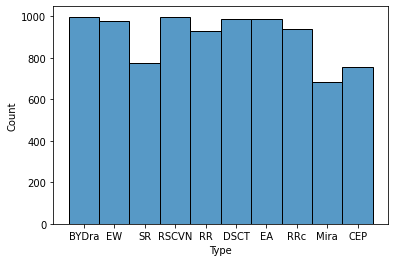

In [7]:
# Plot histogram of variable types in the dataset
import seaborn as sns
sns.histplot(data=df, x=df.Type)

## Various functions to create multiple classifiers

In [8]:
def multiple_to_2labels(df,variable_type):
    """
    converts multiple labels for diffrent variable types to only two labels for one vs all classifier.
    Returns 2 data frames: 
    1. Original data frame with new labels. 
    2. Dataframe with equal candidates of the two classes.
    """
    OneClass = variable_type
    df0 = df.copy()
    df0.loc[df0.Type != OneClass,'Type'] = 'Other'
    df1 = df0[df0.Type == 'Other']
    df2 = df0[df0.Type == OneClass]

    df3 = df1.sample(n=1000, random_state=1) # balance data type by only selecting 1000 of other type
    frames = [df2,df3]
    df_onevsall = pd.concat(frames)
    return df0, df_onevsall

In [9]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
def preprocess_data(df):
    """
    Preprocess data for one vs all classifier and split it to train/test data
    """
    # Map string labels to numbers
    label = df.Type

    le = preprocessing.LabelEncoder()
    le.fit(label)

    # Drop columns that are not features
    X = df
    # Encode labels to form y labels
    y = le.transform(df.Type)

    # Split dataset into training set and test set
    X_tr, X_ts, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test
    X_train = X_tr.drop(['Type','sourceid', 'RAdeg','DEdeg','ID'],axis='columns')
    X_test = X_ts.drop(['Type','sourceid', 'RAdeg','DEdeg','ID'],axis='columns')
    return X_train, X_test, y_train, y_test
    

In [10]:

from sklearn import metrics
# from sklearn.metrics import confusion_matrix
def oneVSall_classiffier(name,model,X_train, X_test, y_train, y_test):
    """
    Train Classifier using train dataset. Calculate classifier metrics using test dataset
    """
    #Train the model using the training sets y_pred=clf.predict(X_test)
    if name == ("Isolation Forest" or "One Class SVM"):
        X_train = X_train[y_train==0]
        model.fit(X_train)
    else:
        model.fit(X_train,y_train)

    # Predict test data output
    y_pred = model.predict(X_test)
    
    # Estimate model performance on test data
    if name == "Isolation Forest" or "One Class SVM":
        one_index = np.where(y_pred==1)
        y_pred[one_index] = 1
        negone_index = np.where(y_pred==-1)
        y_pred[negone_index] = 0
    accuracy = metrics.accuracy_score(y_test, y_pred)
    confusion = metrics.confusion_matrix(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
                                      
    return model, accuracy, precision, recall, confusion

## Train and Compare Classifiers

In [11]:
# list of classification methods
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier
from sklearn.svm import OneClassSVM

names = ["Isolation Forest", "One Class SVM", "XG Boost","Random Forest", "Decision Tree", "Logistic Regression", "Naive Bayes"]

classifiers = [
    IsolationForest(contamination=0.01),
    OneClassSVM(gamma='scale', nu=0.01),
    XGBClassifier(),
    RandomForestClassifier(n_estimators=100),
    DecisionTreeClassifier(criterion="gini", max_depth=3),
    LogisticRegression(max_iter = 500),
    GaussianNB()]
    


In [12]:
# Run loop to train all classifiers and collect metrics in a dataframe
accuracy ={}
precision = {}
recall = {}
confusion ={}

# create comparision dataframe
header = pd.MultiIndex.from_product([names,
                                     ['accuracy','precision','recall']],
                                    names=['classifier','metric'])
index_label = label
pd_comparison = pd.DataFrame(data=None, index=index_label, columns=header, dtype=None, copy=False)

# train models and collect metrics on test data
for name, clf in zip(names, classifiers): # loop over different classifiers
    print(name)
    accuracy[name] = {}
    precision[name] = {}
    recall[name] = {}
    confusion[name] ={}
    for variable_type in label: #loop over different types of variable stars
        print(variable_type)
        df0, df_onevsall = multiple_to_2labels(df,variable_type)
        X_train, X_test, y_train, y_test = preprocess_data(df_onevsall)
        clf, accuracy[name][variable_type],precision[name][variable_type],recall[name][variable_type], confusion[name][variable_type] = oneVSall_classiffier(name,clf,X_train, X_test, y_train, y_test)
    pd_comparison.loc[:,(name,'accuracy')] = list(accuracy[name].values())
    pd_comparison.loc[:,(name,'precision')] = list(precision[name].values())
    pd_comparison.loc[:,(name,'recall')] = list(recall[name].values())

Isolation Forest
BYDra
EW
SR
RSCVN
RR
DSCT
EA
RRc
Mira
CEP
One Class SVM
BYDra
EW
SR
RSCVN
RR
DSCT
EA
RRc
Mira
CEP
XG Boost
BYDra


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:30:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
EW


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:30:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
SR


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:30:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
RSCVN
[12:30:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


RR
[12:31:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


DSCT


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:31:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
EA


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:31:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
RRc


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:31:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Mira
[12:31:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


CEP
[12:32:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Random Forest
BYDra
EW
SR
RSCVN
RR
DSCT
EA
RRc
Mira
CEP
Decision Tree
BYDra
EW
SR
RSCVN
RR
DSCT
EA
RRc
Mira
CEP
Logistic Regression
BYDra


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


EW


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SR


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RSCVN
RR


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DSCT


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


EA


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RRc


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Mira


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CEP


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Naive Bayes
BYDra
EW
SR
RSCVN
RR
DSCT
EA
RRc
Mira
CEP


In [13]:
print(confusion['XG Boost']['EW'])

[[268  24]
 [ 44 257]]


In [14]:
print(confusion['Decision Tree']['RR'])

[[268  30]
 [ 23 258]]


In [15]:
print(confusion['One Class SVM']['EW'])

[[  3 277]
 [  2 311]]


In [16]:
print(confusion['XG Boost']['BYDra'])

[[255  33]
 [ 61 251]]


In [17]:
print(confusion['Naive Bayes']['BYDra'])

[[278   8]
 [200 114]]


In [18]:
# print the comparision table
pd_comparison.head(20)

classifier Isolation Forest                     One Class SVM            \
metric             accuracy precision    recall      accuracy precision   
BYDra              0.378333  0.425287  0.752542      0.491667  0.493289   
EW                 0.413153  0.457944  0.808581      0.529511  0.528912   
SR                 0.433396  0.433396  1.000000      0.433396  0.434535   
RSCVN              0.520000  0.518395  1.000000      0.513333  0.512733   
RR                 0.509499  0.506087  1.000000      0.481865  0.473592   
DSCT               0.387584  0.428302  0.785467      0.491611  0.494881   
EA                 0.400335  0.449905  0.780328      0.484087  0.489796   
RRc                0.498282  0.498282  1.000000      0.469072  0.464223   
Mira               0.508911  0.553879  0.862416      0.601980  0.601980   
CEP                0.453510  0.508584  0.800676      0.580645  0.581081   

classifier            XG Boost                     Random Forest  ...  \
metric        recall  accuracy precision    recall      accuracy  ...   
BYDra       0.989899  0.843333  0.883803  0.804487      0.840000  ...   
EW          0.993610  0.885329  0.914591  0.853821      0.902192  ...   
SR          0.982833  0.842402  0.850000  0.785714      0.829268  ...   
RSCVN       0.983713  0.796667  0.788820  0.824675      0.801667  ...   
RR          0.996296  0.943005  0.952555  0.928826      0.927461  ...   
DSCT        0.976431  0.848993  0.850340  0.844595      0.813758  ...   
EA          0.972973  0.953099  0.924092  0.982456      0.958124  ...   
RRc         0.992537  0.917526  0.901099  0.921348      0.900344  ...   
Mira        1.000000  0.994059  1.000000  0.989583      0.992079  ...   
CEP         0.986885  0.933586  0.951140  0.935897      0.916509  ...   

classifier           Decision Tree                     Logistic Regression  \
metric        recall      accuracy precision    recall            accuracy   
BYDra       0.794613      0.795000  0.881423  0.705696            0.825000   
EW          0.882943      0.804384  0.767516  0.848592            0.706577   
SR          0.745690      0.733583  0.835821  0.482759            0.836773   
RSCVN       0.833866      0.741667  0.722397  0.773649            0.783333   
RR          0.934066      0.908463  0.895833  0.918149            0.898100   
DSCT        0.781250      0.771812  0.827731  0.674658            0.817114   
EA          0.954397      0.948074  0.960993  0.931271            0.949749   
RRc         0.893773      0.826460  0.801948  0.860627            0.867698   
Mira        0.993311      0.982178  0.990196  0.980583            1.000000   
CEP         0.925676      0.755218  0.867769  0.684039            0.882353   

classifier                     Naive Bayes                      
metric     precision    recall    accuracy precision    recall  
BYDra       0.913934  0.726384    0.653333  0.934426  0.363057  
EW          0.687050  0.687050    0.593592  0.984127  0.205298  
SR          0.839024  0.761062    0.499062  0.465066  0.906383  
RSCVN       0.722826  0.904762    0.668333  0.588235  0.964286  
RR          0.866894  0.927007    0.803109  0.703081  0.969112  
DSCT        0.851301  0.768456    0.656040  0.909910  0.341216  
EA          0.953988  0.953988    0.634841  0.981132  0.325000  
RRc         0.857143  0.878049    0.802405  0.731156  0.973244  
Mira        1.000000  1.000000    0.990099  0.993220  0.989865  
CEP         0.874576  0.911661    0.648956  0.945205  0.438095  

[10 rows x 21 columns]

In [19]:
pd_comparison.to_csv('comparison_unbalanced.csv')